# Mutual Information Gradient Estimation (MIGE) Toy Experiment

## Imports

Requirements:

- pytorch >= 1.2.0
- numpy
- tqdm
- matplotlib

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

## Correlated Gaussian Problem

$d$-d correlated gaussian variables $x$ and $y$, where $\mathrm{corr}(x_i, y_i) = \delta_{ij} \rho, \rho \in (-1, 1)$,

### Data Generator

Generate random variable $X \sim N(0,1)$ and noise $\epsilon \sim N(0,1)$,

$Y = \rho X + \sqrt{1-\rho^2} \epsilon$, then $(X, Y)$ is the correlated gaussian.

In [2]:
def GenerateSamples(d, rho, num_sample):
    xs = torch.randn(num_sample, d).cuda()
    noise = torch.randn(num_sample, d).cuda()
    ys = rho * xs + (1-rho**2)**0.5 * noise
    xs_ys = torch.cat([xs, ys], dim=-1)
    return xs_ys, xs, ys

### True Values

True MI $I(x; y)= - \frac{d}{2} \ln (1-\rho^2)$,

True gradient $\nabla_\rho I(x; y) = \frac{\rho d}{1-\rho^2}$.

In [3]:
def ComputeTrueValues(d, axis_min, axis_max):
    num_point = 256
    rho = np.linspace(axis_min, axis_max, num_point)
    mi = - np.log(1 - rho ** 2) * d / 2
    gradient = (rho * d) / (1 - rho ** 2)

    np.savez('results/true_{}.npz'.format(d), rho=rho, mi=mi, gradient=gradient)

    print('Complete: {}-d true values.'.format(d))
    print('  Save as: true_{}.npz'.format(d))

## MINE

Mutual Information Neural Estimation (MINE), proposed by [1], requires a neural network to approximate MI.

[1]. Mohamed Ishmael Belghazi, Aristide Baratin, Sai Rajeswar, Sherjil Ozair, Yoshua Bengio, Aaron Courville, and R Devon Hjelm. Mine: mutual information neural estimation. ICML, 2018.

In [4]:
class Net(nn.Module):
    def __init__(self, d, H):
        super().__init__()
        self.d = d
        self.H = H
        self.fc1 = nn.Linear(self.d, self.H)
        self.fc2 = nn.Linear(self.H, self.H)
        self.fc3 = nn.Linear(self.H, 20)

    def forward(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        h3 = self.fc3(h2)
        return h3

### MINE (DV)

MINE use KL Donsker-Varadhan lower bound,

$D_{KL}(\mathbb{P} \| \mathbb{Q}) \geq \sup_{T \in F} \mathbb{E}_{\mathbb{P}}[T] - \log(\mathbb{E}_{\mathbb{Q}}[e^T])$.

Let $F=\left\{ T_{\theta}\right\}_{\theta \in \Theta}$ be the set of functions parametrized by a neural network, MINE(DV) is defined as,

$\widehat{I(x;y)} = \sup_{\theta \in \Theta}  \mathbb{E}_{\mathbb{P}_{xy}^n} \left[ T_{\theta} \right] - \log \left( \mathbb{E}_{\mathbb{P}_{x}^n \mathbb{P}_y^n} \left[ e^T_{\theta} \right] \right)$.

Stochastic mini-batch leads to a biased estimation. To reduce it, exponential moving average should be applied.

In [5]:
class EMA():
    def __init__(self, model, decay):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}

    def register(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                new_average = (1.0 - self.decay) * param.data + self.decay * self.shadow[name]
                self.shadow[name] = new_average.clone()

    def apply_shadow(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                self.backup[name] = param.data
                param.data = self.shadow[name]

    def restore(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.backup
                param.data = self.backup[name]
        self.backup = {}

In [6]:
def MINE_DV(d, range_rho, num_sample, num_epoch, num_hidden_unit, GenerateData):
    MI_approximation = []
    gradient_approximation = []
    for rho in range_rho:
        model1 = Net(d, num_hidden_unit).cuda()
        model2 = Net(d, num_hidden_unit).cuda()
        ema1 = EMA(model1, 0.999)
        ema2 = EMA(model2, 0.999)
        ema1.register()
        ema2.register()
        optimizer = torch.optim.Adam([
            {'params': model1.parameters()},
            {'params': model2.parameters()}
        ], lr=1e-4)

        rho = torch.FloatTensor([rho]).cuda()
        rho.requires_grad = True

        for epoch in range(num_epoch):
            xs_ys, xs, ys = GenerateData(d, rho, num_sample)

            pred_x = model1(xs)
            pred_y = model2(ys)
            us = pred_x @ pred_y.T

            mask = torch.eye(num_sample).cuda()
            n_mask = 1 - mask

            E_pos = torch.sum(mask * us) / num_sample
            E_neg = torch.log(torch.sum(torch.exp(us) * n_mask) / (num_sample ** 2 - num_sample))
            MI = E_pos - E_neg
            loss = - MI

            model1.zero_grad()
            model2.zero_grad()
            loss.backward(retain_graph=True)

            if epoch == num_epoch - 1:
                MI_approximation.append(MI)
                gradient_approximation.append(-rho.grad.data)
            else:
                rho.grad.data.zero_()
                optimizer.step()
                ema1.update()
                ema2.update()
                ema1.apply_shadow()
                ema2.apply_shadow()
        del model1, model2
        del ema1, ema2

    gradient_approximation = torch.stack(gradient_approximation).view(-1).detach().cpu().numpy()
    MI_approximation = torch.stack(MI_approximation).view(-1).detach().cpu().numpy()
    return gradient_approximation, MI_approximation

In [7]:
def ComputeMINE(d, axis_min, axis_max, num_lines):
    print('Compute MINE(DV) estimation, d={}'.format(d))

    num_point = 30
    num_sample = 256
    num_epoch = 200
    num_units = 512

    rho = np.linspace(axis_min, axis_max, num_point)
    mi, gradient = [], []

    for i in tqdm(range(num_lines)):
        g, m = MINE_DV(d, rho, num_sample, num_epoch, num_units, GenerateSamples)
        mi.append(m)
        gradient.append(g)

    mi = np.stack(mi, axis=0)
    gradient = np.stack(gradient, axis=0)

    np.savez('results/mine_{}.npz'.format(d), rho=rho, mi=mi, gradient=gradient)
    print('Complete: {} times {}-d mine estimation.'.format(num_lines, d))
    print('  Save as: mine_{}.npz'.format(d))

### MINE (f)

MINE($f$) use another practicable MI lower bound, the NWJ bound, which is defined as,

$D_{KL}(\mathbb{P} \| \mathbb{Q}) \geq \sup_{T \in F} \mathbb{E}_{\mathbb{P}}[T] - \mathbb{E}_{\mathbb{Q}}[e^{T-1}]$.

In [8]:
def MINE_NWJ(d, range_rho, num_sample, num_epoch, num_hidden_unit, GenerateData):
    MI_approximation = []
    gradient_approximation = []
    for rho in range_rho:
        model1 = Net(d, num_hidden_unit).cuda()
        model2 = Net(d, num_hidden_unit).cuda()
        optimizer = torch.optim.Adam([
            {'params': model1.parameters()},
            {'params': model2.parameters()}
        ], lr=1e-4)

        rho = torch.FloatTensor([rho]).cuda()
        rho.requires_grad = True

        for epoch in range(num_epoch):
            xs_ys, xs, ys = GenerateData(d, rho, num_sample)

            pred_x = model1(xs)
            pred_y = model2(ys)
            us = pred_x @ pred_y.T

            mask = torch.eye(num_sample).cuda()
            n_mask = 1 - mask

            E_pos = torch.sum(us * mask) / num_sample
            E_neg = torch.sum((torch.exp(us - 1.0) * n_mask)) / (num_sample ** 2 - num_sample)
            MI = E_pos - E_neg
            loss = - MI

            model1.zero_grad()
            model2.zero_grad()
            loss.backward(retain_graph=True)

            if epoch == num_epoch - 1:
                MI_approximation.append(MI)
                gradient_approximation.append(-rho.grad.data)
            else:
                rho.grad.data.zero_()
                optimizer.step()
        del model1, model2

    gradient_approximation = torch.stack(gradient_approximation).view(-1).detach().cpu().numpy()
    MI_approximation = torch.stack(MI_approximation).view(-1).detach().cpu().numpy()
    return gradient_approximation, MI_approximation

In [9]:
def ComputeMINE_F(d, axis_min, axis_max, num_lines):
    print('Compute MINE-f(NWJ) estimation, d={}'.format(d))

    num_point = 30
    num_sample = 256
    num_epoch = 200
    num_units = 512

    rho = np.linspace(axis_min, axis_max, num_point)
    mi, gradient = [], []

    for i in tqdm(range(num_lines)):
        g, m = MINE_NWJ(d, rho, num_sample, num_epoch, num_units, GenerateSamples)
        mi.append(m)
        gradient.append(g)

    mi = np.stack(mi, axis=0)
    gradient = np.stack(gradient, axis=0)

    np.savez('results/mine-f_{}.npz'.format(d), rho=rho, mi=mi, gradient=gradient)
    print('Complete: {} times {}-d mine-f estimation.'.format(num_lines, d))
    print('  Save as: mine-f_{}.npz'.format(d))

## SSGE

MIGE is rely on the implicit distributions' score estimation method Spectral Stein Gradient Estimation (SSGE)[2]. We implement a PyTorch version.


The official SSGE implementation (tensorflow):
https://github.com/thjashin/spectral-stein-grad

[2]. Jiaxin Shi, Shengyang Sun, and Jun Zhu. A spectral approach to gradient estimation for implicit distributions. arXiv preprint arXiv:1806.02925, 2018.

In [10]:
class ScoreEstimator:
    def __init__(self):
        pass

    def rbf_kernel(self, x1, x2, kernel_width):
        return torch.exp(
            -torch.sum(torch.mul((x1 - x2), (x1 - x2)), dim=-1) / (2 * torch.mul(kernel_width, kernel_width))
        )

    def gram(self, x1, x2, kernel_width):
        x_row = torch.unsqueeze(x1, -2)
        x_col = torch.unsqueeze(x2, -3)
        kernel_width = kernel_width[..., None, None]
        return self.rbf_kernel(x_row, x_col, kernel_width)

    def grad_gram(self, x1, x2, kernel_width):
        x_row = torch.unsqueeze(x1, -2)
        x_col = torch.unsqueeze(x2, -3)
        kernel_width = kernel_width[..., None, None]
        G = self.rbf_kernel(x_row, x_col, kernel_width)
        diff = (x_row - x_col) / (kernel_width[..., None] ** 2)
        G_expand = torch.unsqueeze(G, -1)
        grad_x2 = G_expand * diff
        grad_x1 = G_expand * (-diff)
        return G, grad_x1, grad_x2

    def heuristic_kernel_width(self, x_samples, x_basis):
        n_samples = x_samples.size()[-2]
        n_basis = x_basis.size()[-2]
        x_samples_expand = torch.unsqueeze(x_samples, -2)
        x_basis_expand = torch.unsqueeze(x_basis, -3)
        pairwise_dist = torch.sqrt(
            torch.sum(torch.mul(x_samples_expand - x_basis_expand, x_samples_expand - x_basis_expand), dim=-1)
        )
        k = n_samples * n_basis // 2
        top_k_values = torch.topk(torch.reshape(pairwise_dist, [-1, n_samples * n_basis]), k=k)[0]
        kernel_width = torch.reshape(top_k_values[:, -1], x_samples.size()[:-2])
        return kernel_width.detach()

    def compute_gradients(self, samples, x=None):
        raise NotImplementedError()
        

In [11]:
class SpectralScoreEstimator(ScoreEstimator):
    def __init__(self, n_eigen=None, eta=None, n_eigen_threshold=None):
        self._n_eigen = n_eigen
        self._eta = eta
        self._n_eigen_threshold = n_eigen_threshold
        super().__init__()

    def nystrom_ext(self, samples, x, eigen_vectors, eigen_values, kernel_width):
        M = torch.tensor(samples.size()[-2]).to(samples.device)
        Kxq = self.gram(x, samples, kernel_width)
        ret = torch.sqrt(M.float()) * torch.matmul(Kxq, eigen_vectors)
        ret *= 1. / torch.unsqueeze(eigen_values, dim=-2)
        return ret

    def compute_gradients(self, samples, x=None):
        if x is None:
            kernel_width = self.heuristic_kernel_width(samples, samples)
            x = samples
        else:
            _samples = torch.cat([samples, x], dim=-2)
            kernel_width = self.heuristic_kernel_width(_samples, _samples)

        M = samples.size()[-2]
        Kq, grad_K1, grad_K2 = self.grad_gram(samples, samples, kernel_width)
        if self._eta is not None:
            Kq += self._eta * torch.eye(M)

        eigen_values, eigen_vectors = torch.symeig(Kq, eigenvectors=True, upper=True)

        if (self._n_eigen is None) and (self._n_eigen_threshold is not None):
            eigen_arr = torch.mean(
                torch.reshape(eigen_values, [-1, M]), dim=0)

            eigen_arr = torch.flip(eigen_arr, [-1])
            eigen_arr /= torch.sum(eigen_arr)
            eigen_cum = torch.cumsum(eigen_arr, dim=-1)
            eigen_lt = torch.lt(eigen_cum, self._n_eigen_threshold)
            self._n_eigen = torch.sum(eigen_lt)
        if self._n_eigen is not None:
            eigen_values = eigen_values[..., -self._n_eigen:]
            eigen_vectors = eigen_vectors[..., -self._n_eigen:]
        eigen_ext = self.nystrom_ext(samples, x, eigen_vectors, eigen_values, kernel_width)
        grad_K1_avg = torch.mean(grad_K1, dim=-3)
        M = torch.tensor(M).to(samples.device)
        beta = -torch.sqrt(M.float()) * torch.matmul(torch.transpose(eigen_vectors, -1, -2),
                                                     grad_K1_avg) / torch.unsqueeze(eigen_values, -1)
        grads = torch.matmul(eigen_ext, beta)
        self._n_eigen = None
        return grads


## MIGE

Our method

In [12]:
def entropy_surrogate(estimator, samples):
    dlog_q = estimator.compute_gradients(samples.detach(), None)
    surrogate_cost = torch.mean(torch.sum(dlog_q.detach() * samples, -1))
    return surrogate_cost


def MIGE(d, range_rho, num_sample, GenerateData, threshold=None, n_eigen=None):
    spectral_j = SpectralScoreEstimator(n_eigen=n_eigen, n_eigen_threshold=threshold)
    spectral_m = SpectralScoreEstimator(n_eigen=n_eigen, n_eigen_threshold=threshold)
    approximations = []
    for rho in range_rho:
        rho = torch.FloatTensor([rho]).cuda()
        rho.requires_grad = True
        xs_ys, xs, ys = GenerateData(d, rho, num_sample)

        ans = entropy_surrogate(spectral_j, xs_ys) \
              - entropy_surrogate(spectral_m, ys)

        ans.backward()
        approximations.append(rho.grad.data)

    approximations = torch.stack(approximations).view(-1).detach().cpu().numpy()
    return approximations

In [13]:
def ComputeMIGE(d, axis_min, axis_max, num_lines):
    print('Compute MIGE estimation, d={}'.format(d))

    num_point = 32
    num_sample = 256

    rho = np.linspace(axis_min, axis_max, num_point)
    gradient = []

    for i in tqdm(range(num_lines)):
        g = MIGE(d, rho, num_sample, GenerateSamples, threshold=0.99)
        gradient.append(g)

    gradient = np.stack(gradient, axis=0)

    np.savez('results/mige_{}.npz'.format(d), rho=rho, gradient=gradient)
    print('Complete: {} times {}-d mige estimation.'.format(num_lines, d))
    print('  Save as: mige_{}.npz'.format(d))

## Visualization

In [14]:
def Draw(ds, num_lines):
    # Plot Setting
    plt.figure(figsize=(3.8 * len(ds), 3.6 * 2))

    for i in range(len(ds)):
        d = ds[i]
        true_value = np.load('results/true_{}.npz'.format(d))
        true_r, true_mi, true_g = true_value['rho'], true_value['mi'], true_value['gradient']
        mine_value = np.load('results/mine_{}.npz'.format(d))
        mine_r, mine_mi, mine_g = mine_value['rho'], mine_value['mi'], mine_value['gradient']
        mine_f_value = np.load('results/mine-f_{}.npz'.format(d))
        mine_f_r, mine_f_mi, mine_f_g = mine_f_value['rho'], mine_f_value['mi'], mine_f_value['gradient']
        mige_value = np.load('results/mige_{}.npz'.format(d))
        mige_r, mige_g = mige_value['rho'], mige_value['gradient']

        plt.subplot(2, len(ds), i + 1)
        for j in range(num_lines - 1):
            plt.plot(mine_r, mine_mi[j], color='C1', alpha=0.1, linewidth=1.5)
        for j in range(num_lines - 1):
            plt.plot(mine_f_r, mine_f_mi[j], color='C2', alpha=0.1, linewidth=1.5)
        plt.plot(true_r, true_mi, label=r'True MI', linewidth=1.5)
        plt.plot(mine_r, mine_mi[num_lines - 1], label=r'MINE', color='C1', linewidth=1.5)
        plt.plot(mine_f_r, mine_f_mi[num_lines - 1], label=r'MINE-$f$', color='C2', linewidth=1.5)
        plt.title('d = {}'.format(d), fontsize=16)
        plt.grid(True, linestyle='-.')
        plt.tick_params(labelbottom=False)
        if i == 0:
            plt.ylabel('Mutual Information', fontsize=16)
            plt.legend(loc='upper left', prop={'size': 12})

        plt.subplot(2, len(ds), len(ds) + i + 1)
        for j in range(num_lines - 1):
            plt.plot(mine_r, mine_g[j], color='C1', alpha=0.1, linewidth=1.5)
        for j in range(num_lines - 1):
            plt.plot(mine_f_r, mine_f_g[j], color='C2', alpha=0.1, linewidth=1.5)
        for j in range(num_lines - 1):
            plt.plot(mige_r, mige_g[j], color='C3', alpha=0.1, linewidth=1.5)
        plt.plot(true_r, true_g, label='True Gradient', linewidth=1.5)
        plt.plot(mine_r, mine_g[num_lines - 1], label=r'$\nabla_{\rho}$ MINE', color='C1', linewidth=1.5)
        plt.plot(mine_f_r, mine_f_g[num_lines - 1], label=r'$\nabla_{\rho}$ MINE-$f$', color='C2', linewidth=1.5)
        plt.plot(mige_r, mige_g[num_lines - 1], label='MIGE (ours)', color='C3', linewidth=1.5)
        plt.xlabel(r'$\rho$', fontsize=16)
        plt.grid(True, linestyle='-.')
        if i == 0:
            plt.ylabel('Gradient', fontsize=16)
            plt.legend(loc='upper left', prop={'size': 12})

    plt.tight_layout()
    plt.savefig('./toy.pdf', format='pdf')
    plt.show()

## Calculate

MINE and MINE-$f$ have a neural network optimization process, it may take several minutes.

MIGE takes only a few seconds.

Results saved to ./results

In [15]:
ds = [8, 16, 32]
num_lines = 1
axis_min, axis_max = -0.8, 0.8

for d in ds:
    ComputeTrueValues(d, axis_min, axis_max)

for d in ds:
    ComputeMINE(d, axis_min, axis_max, num_lines)

for d in ds:
    ComputeMINE_F(d, axis_min, axis_max, num_lines)

for d in ds:
    ComputeMIGE(d, axis_min, axis_max, num_lines)

  0%|          | 0/1 [00:00<?, ?it/s]

Complete: 8-d true values.
  Save as: true_8.npz
Complete: 16-d true values.
  Save as: true_16.npz
Complete: 32-d true values.
  Save as: true_32.npz
Compute MINE(DV) estimation, d=8


  0%|          | 0/1 [00:00<?, ?it/s]

Complete: 1 times 8-d mine estimation.
  Save as: mine_8.npz
Compute MINE(DV) estimation, d=16


  0%|          | 0/1 [00:00<?, ?it/s]

Complete: 1 times 16-d mine estimation.
  Save as: mine_16.npz
Compute MINE(DV) estimation, d=32


  0%|          | 0/1 [00:00<?, ?it/s]

Complete: 1 times 32-d mine estimation.
  Save as: mine_32.npz
Compute MINE-f(NWJ) estimation, d=8


  0%|          | 0/1 [00:00<?, ?it/s]

Complete: 1 times 8-d mine-f estimation.
  Save as: mine-f_8.npz
Compute MINE-f(NWJ) estimation, d=16


  0%|          | 0/1 [00:00<?, ?it/s]

Complete: 1 times 16-d mine-f estimation.
  Save as: mine-f_16.npz
Compute MINE-f(NWJ) estimation, d=32


  0%|          | 0/1 [00:00<?, ?it/s]

Complete: 1 times 32-d mine-f estimation.
  Save as: mine-f_32.npz
Compute MIGE estimation, d=8


  0%|          | 0/1 [00:00<?, ?it/s]

Complete: 1 times 8-d mige estimation.
  Save as: mige_8.npz
Compute MIGE estimation, d=16


  0%|          | 0/1 [00:00<?, ?it/s]

Complete: 1 times 16-d mige estimation.
  Save as: mige_16.npz
Compute MIGE estimation, d=32


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

Complete: 1 times 32-d mige estimation.
  Save as: mige_32.npz


## Results

High quality image saved to ./toy.pdf

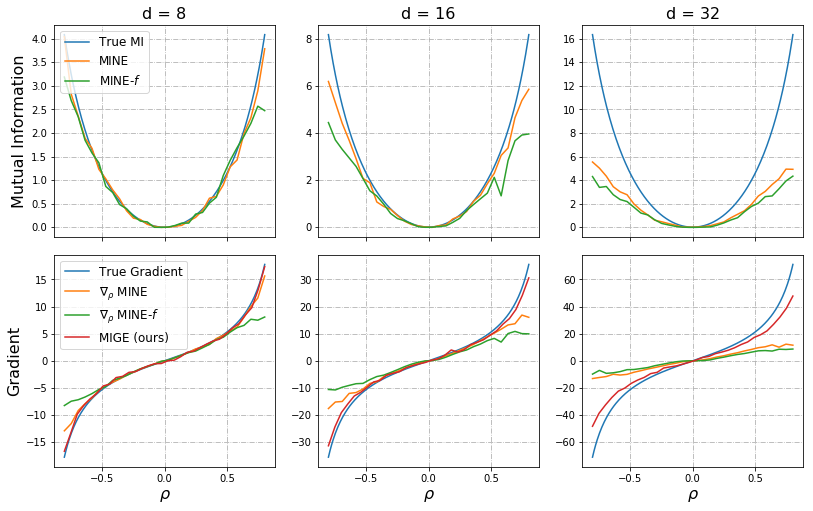

In [16]:
Draw(ds, num_lines)